# Unsupervised ML Final Project: K-Means analysis of Spotify Data
By Bradley Sides

Link to dataset: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset?resource=download

## Step 1: EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.stats import zscore
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [2]:
# NOTE: Using Colab - Adjust for personal system

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/dataset.csv')

In [4]:
# Inspect data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [5]:
# Look into content

df.head()

Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610  ...    -6.746     0       0.1430        0.0322   
1         0.420  0.1660  ...   -17.235     1       0.0763        0.9240   
2         0.438  0.3590  ...    -9.734     1       0.0557        0.2100   
3         0.266  0.0596  ...   -18.515     1       0.0363        0.9050   
4         0.618  0.4430  ...    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature  track_genre  
0          0.000001    0.3580    0.715   87.917               4     acoustic  
1          0.000006    0.1010    0.267   77.489               4     acoustic  
2          0.000000    0.1170    0.120   76.332               4     acoustic  
3          0.000071    0.1320    0.143  181.740               3     acoustic  
4          0.000000    0.0829    0.167  119.949               4     acoustic  

[5 rows x 21 columns]

We will be looking into the audio features of each track, so creating a new dataframe that includes relevant audio features will be helpful to us.

In [5]:
# Filter for audio features

audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
df_features = df[audio_features].copy()

In [6]:
# See how many features are gone

print("Size of dataframe (Before drop): ", len(df_features))
df_features = df_features.dropna()
print("Size of dataframe (After drop): ", len(df_features))

Size of dataframe (Before drop):  114000
Size of dataframe (After drop):  114000


In [7]:
#Outlier detection, use Z-Scores to remove

z_scores = np.abs(zscore(df_features))
df_features = df_features[(z_scores < 3).all(axis = 1)]
print("Size of dataframe (After outlier removal): ", len(df_features))

Size of dataframe (After outlier removal):  106251


In [8]:
df_features = df_features.sample(n = 20000)
print("Final Size: ", len(df_features))

Final Size:  20000


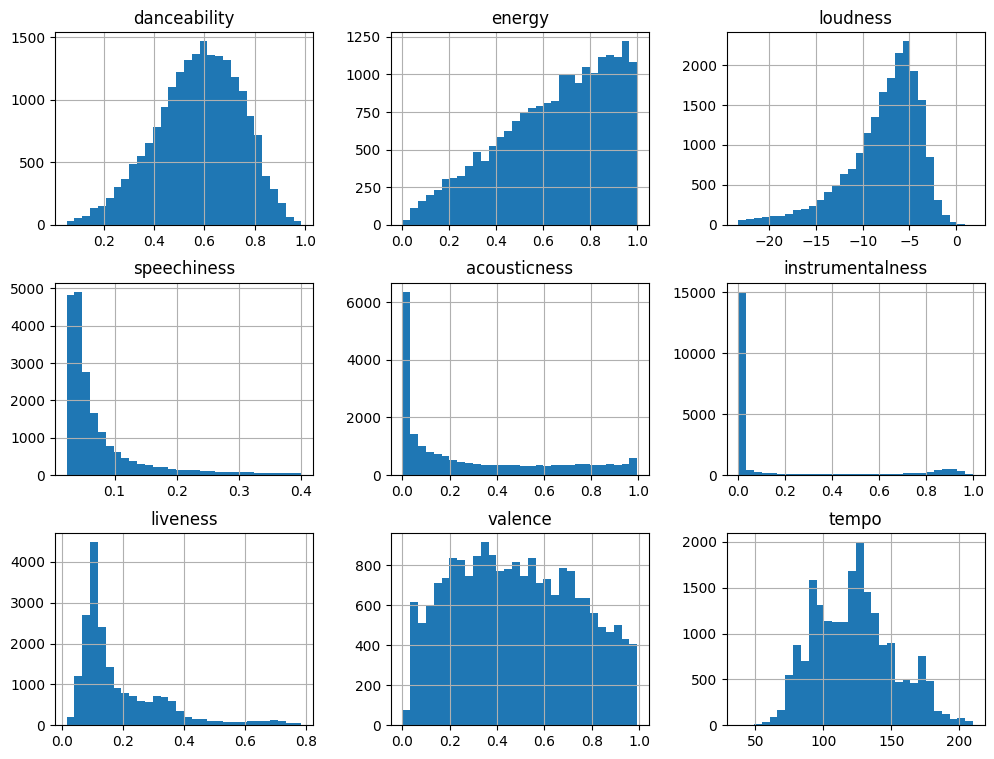

In [9]:
# Visualize key feature distribution

df_features.hist(figsize = (12, 9), bins = 30)
plt.show()

**Key Point:** Here, we can see a few very skewed or very unhelpful distributions. Instrumentalness, speechiness, and acousticness have massive peaks near zero, which will mess with the k-means model later on.

Also, you will notice that the scales are much different. Don't worry, as we will implement a scaler later on.

In [10]:
df_features = df_features.drop(['instrumentalness','acousticness', 'speechiness'], axis = 1)

In [11]:
df_features = df_features.drop(['liveness'], axis = 1)

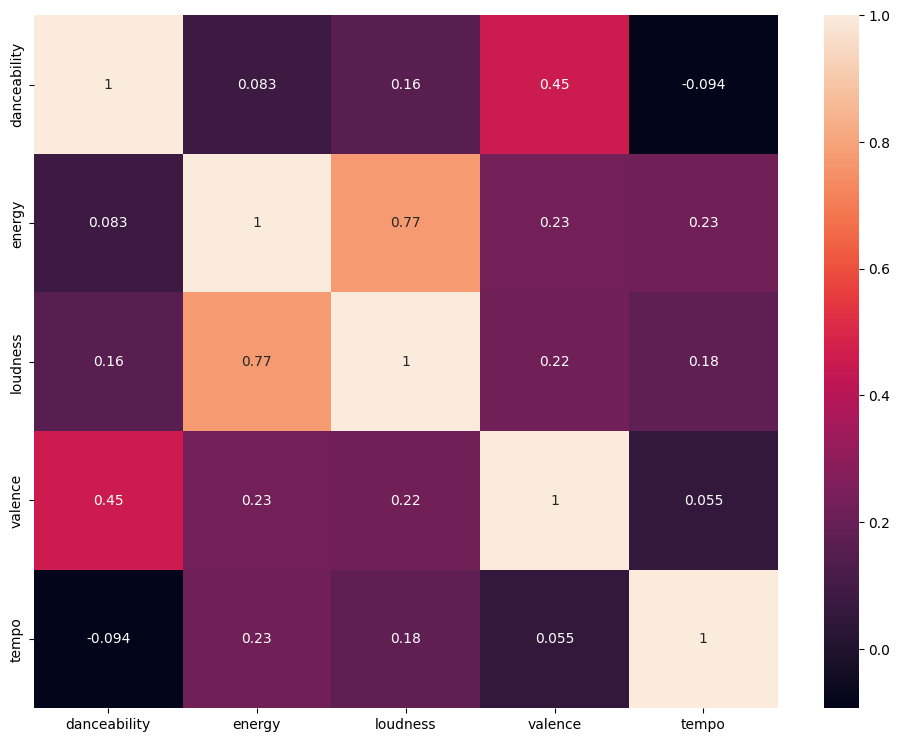

In [12]:
# Feature Correlations

plt.figure(figsize = (12, 9))
sns.heatmap(df_features.corr(), annot = True)
plt.show()

In [13]:
df_features = df_features.drop(['loudness'], axis = 1)

### Final Features

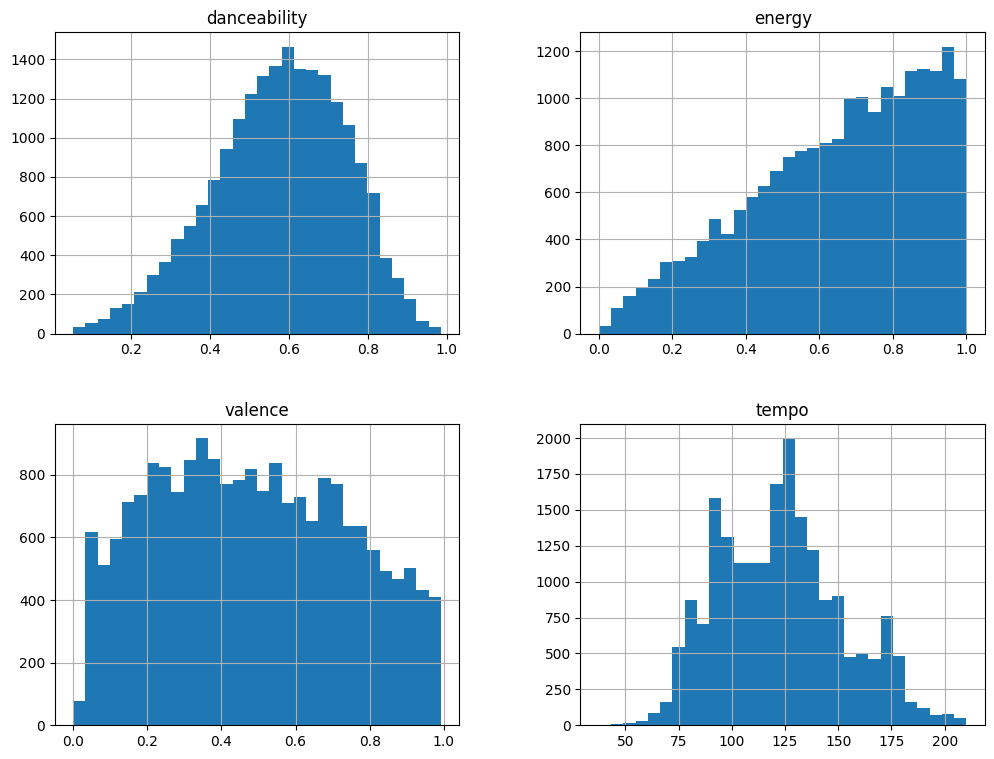

In [14]:
df_features.hist(figsize = (12, 9), bins = 30)
plt.show()

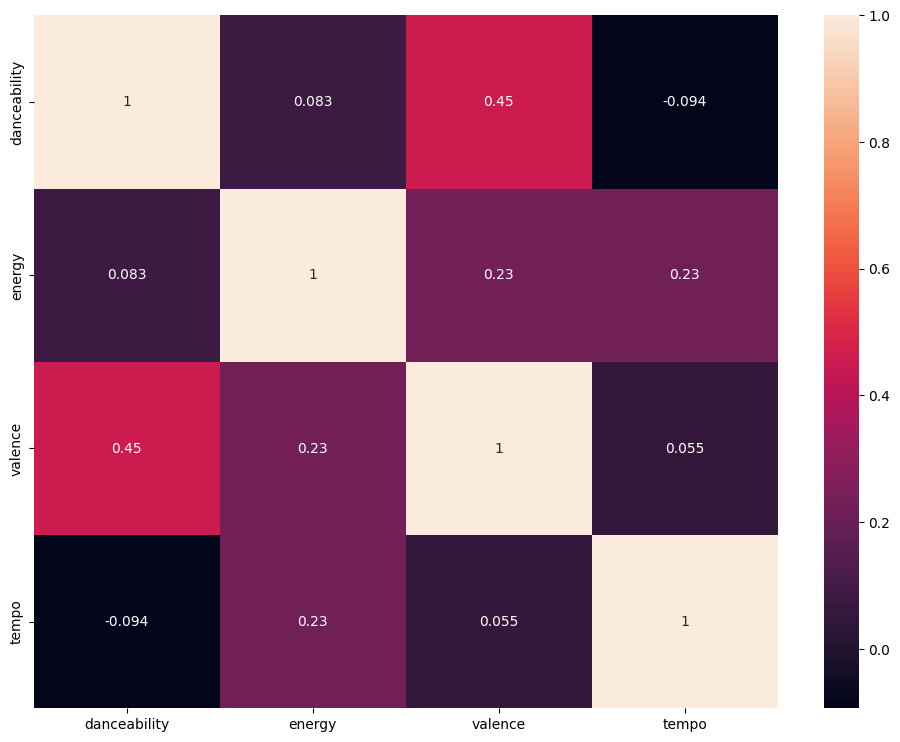

In [15]:
plt.figure(figsize = (12, 9))
sns.heatmap(df_features.corr(), annot = True)
plt.show()

## Step 2: Model Training and Fitting



In [16]:
# Fit data to same scale

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

### Model 1: K-Means

In [17]:
# check different values of K for elbow method

inertia = []
range = range(2, 25)

for k in range:
  print("Optimizing k: ", k)
  kmeans = KMeans(n_clusters = k, n_init = 25)
  kmeans.fit(df_scaled)
  inertia.append(kmeans.inertia_)

Optimizing k:  2
Optimizing k:  3
Optimizing k:  4
Optimizing k:  5
Optimizing k:  6
Optimizing k:  7
Optimizing k:  8
Optimizing k:  9
Optimizing k:  10
Optimizing k:  11
Optimizing k:  12
Optimizing k:  13
Optimizing k:  14
Optimizing k:  15
Optimizing k:  16
Optimizing k:  17
Optimizing k:  18
Optimizing k:  19
Optimizing k:  20
Optimizing k:  21
Optimizing k:  22
Optimizing k:  23
Optimizing k:  24


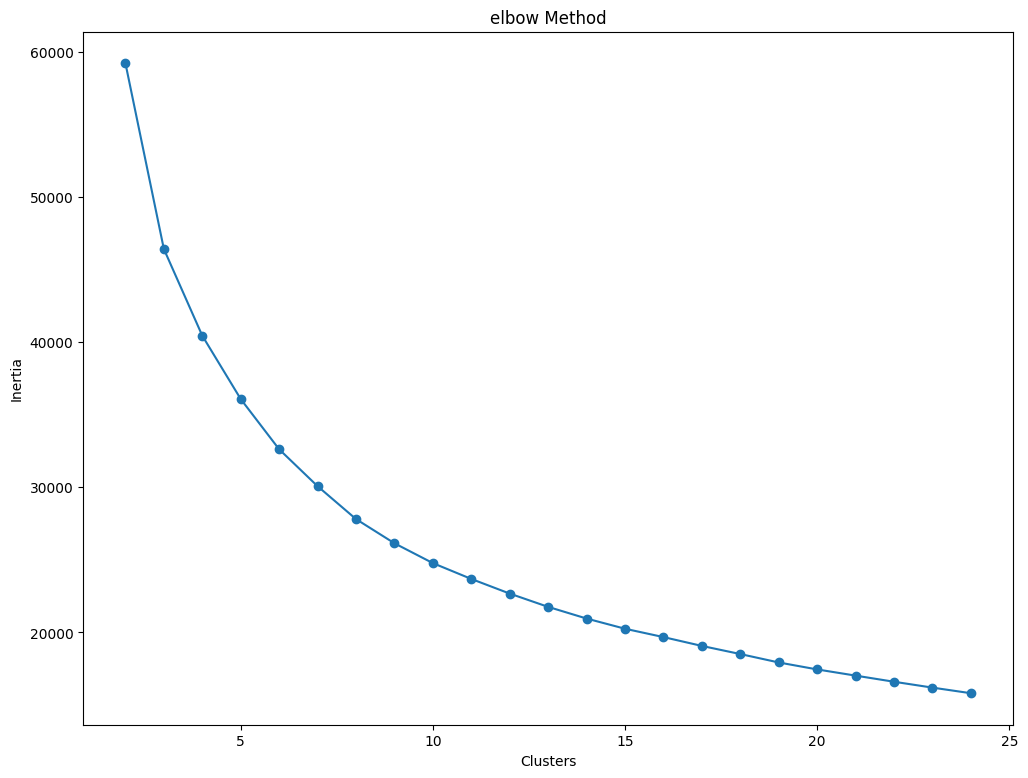

In [18]:
# Plot to see best K

plt.figure(figsize = (12, 9))
plt.plot(range, inertia, marker = 'o')

plt.xlabel("Clusters")
plt.ylabel("Inertia")
plt.title("elbow Method")
plt.show()

In [19]:
# Fit model to best k

best_k = 15

kmeans = KMeans(n_clusters = best_k, n_init = 25)
kmeans_labels = kmeans.fit_predict(df_scaled)

In [20]:
score = silhouette_score(df_scaled, kmeans_labels)
print("Silhouette Score: ", score)

Silhouette Score:  0.19926272827541489


In [21]:
# dimensionality reduction for visualization

pca = PCA(n_components = 2)
df_pca = pca.fit_transform(df_scaled)
df_viz = pd.DataFrame(df_pca, columns = ['PC1', 'PC2'])
df_viz["Cluster"] = kmeans_labels

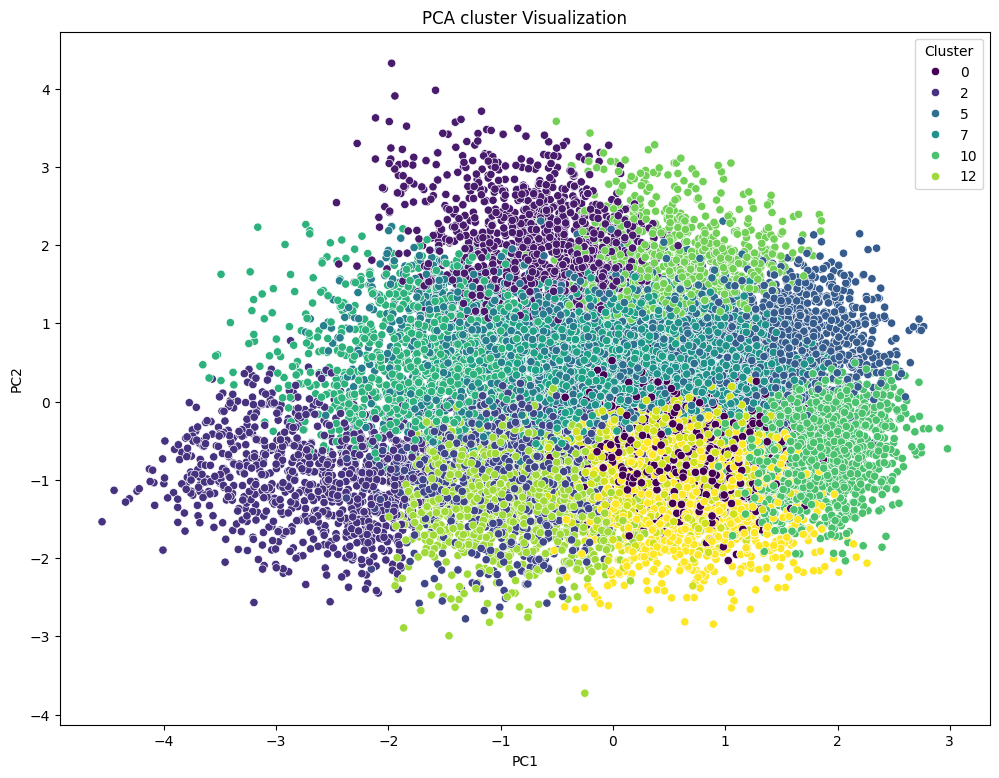

In [22]:
plt.figure(figsize = (12, 9))
sns.scatterplot(x = "PC1", y = "PC2", hue = "Cluster", data = df_viz, palette = 'viridis')
plt.title('PCA cluster Visualization')
plt.show()

### Model 2: GMM

Silhouette Score:  0.12333302513555386


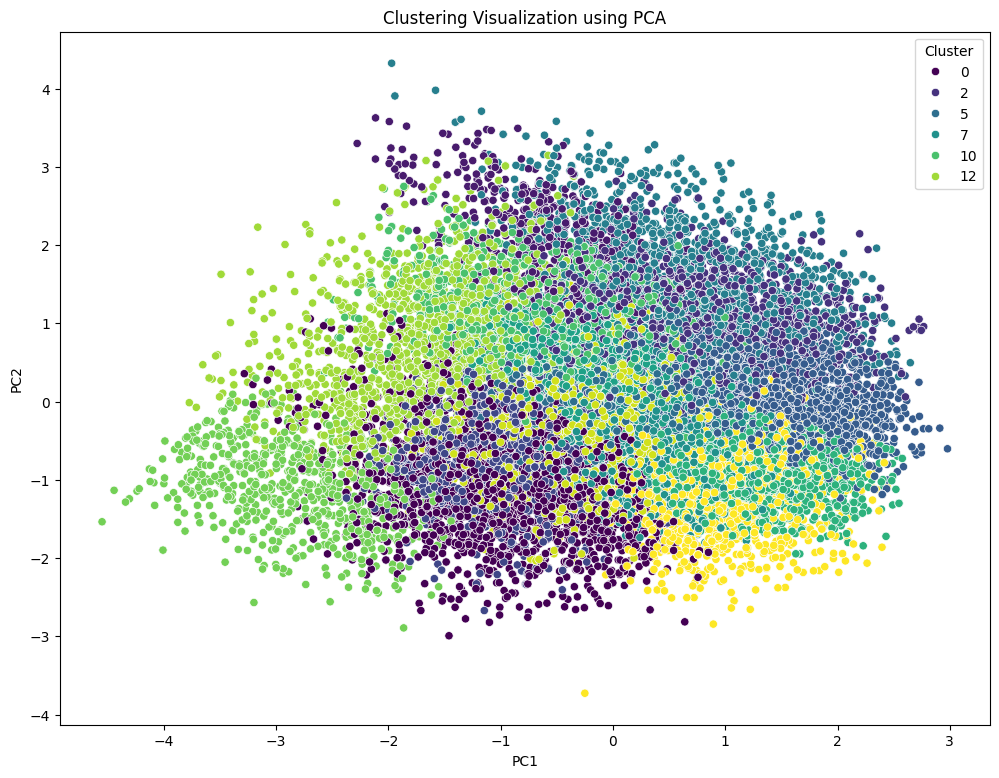

In [23]:
gmm = GaussianMixture(n_components = 15)
gmm_labels = gmm.fit_predict(df_scaled)
score = silhouette_score(df_scaled, gmm_labels)
print("Silhouette Score: ", score)

pca = PCA(n_components = 2)
df_pca = pca.fit_transform(df_scaled)
df_viz = pd.DataFrame(df_pca, columns = ['PC1', 'PC2'])
df_viz["Cluster"] = gmm_labels

plt.figure(figsize = (12, 9))
sns.scatterplot(x = "PC1", y = "PC2", hue = "Cluster", data = df_viz, palette = 'viridis')
plt.title('Clustering Visualization using PCA')
plt.show()

Silhouette Score:  0.18983528122624152


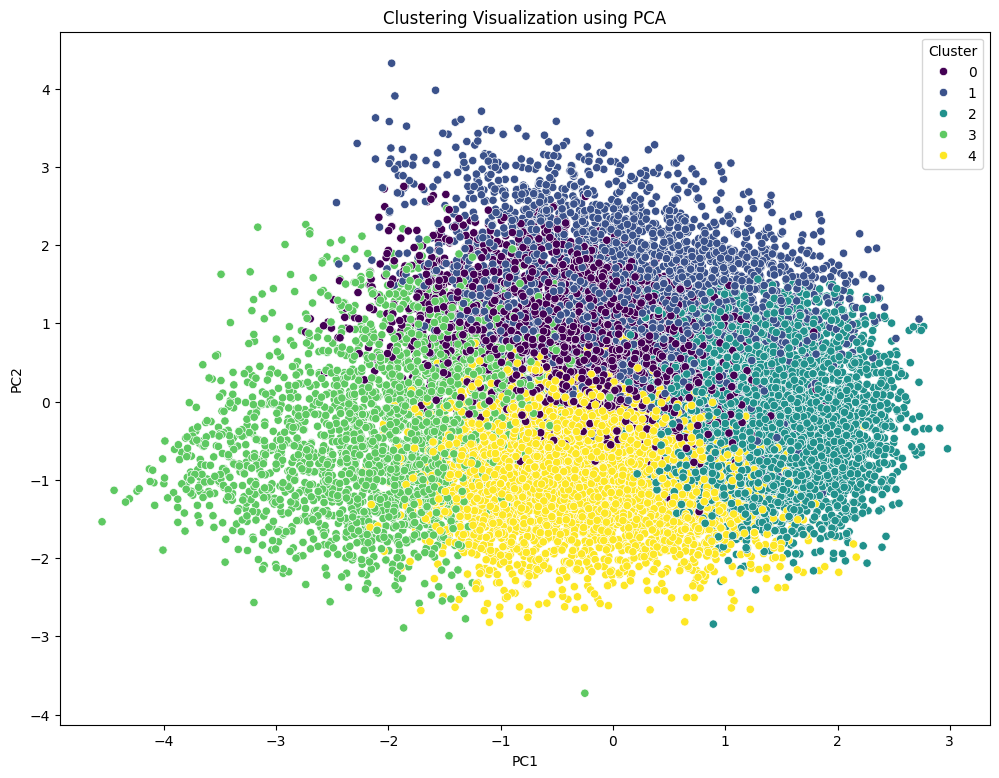

In [24]:
gmm = GaussianMixture(n_components = 5)
gmm_labels = gmm.fit_predict(df_scaled)
score = silhouette_score(df_scaled, gmm_labels)
print("Silhouette Score: ", score)

pca = PCA(n_components = 2)
df_pca = pca.fit_transform(df_scaled)
df_viz = pd.DataFrame(df_pca, columns = ['PC1', 'PC2'])
df_viz["Cluster"] = gmm_labels

plt.figure(figsize = (12, 9))
sns.scatterplot(x = "PC1", y = "PC2", hue = "Cluster", data = df_viz, palette = 'viridis')
plt.title('Clustering Visualization using PCA')
plt.show()

Silhouette Score:  0.2228210139865532


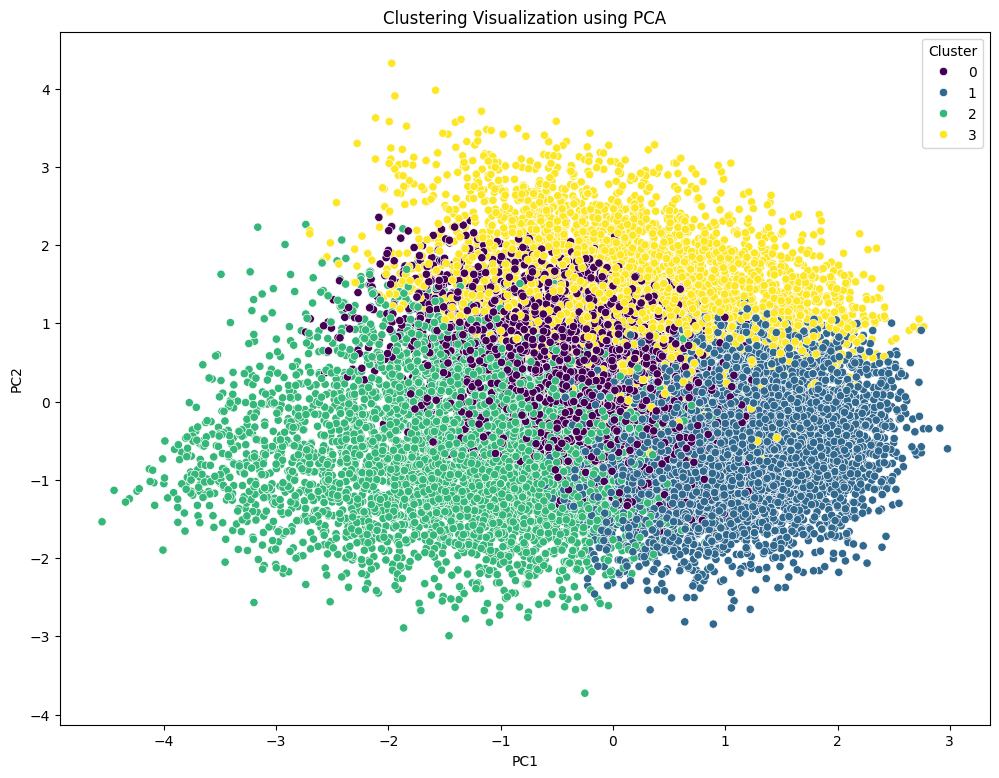

In [25]:
gmm = GaussianMixture(n_components = 4)
gmm_labels = gmm.fit_predict(df_scaled)
score = silhouette_score(df_scaled, gmm_labels)
print("Silhouette Score: ", score)

pca = PCA(n_components = 2)
df_pca = pca.fit_transform(df_scaled)
df_viz = pd.DataFrame(df_pca, columns = ['PC1', 'PC2'])
df_viz["Cluster"] = gmm_labels

plt.figure(figsize = (12, 9))
sns.scatterplot(x = "PC1", y = "PC2", hue = "Cluster", data = df_viz, palette = 'viridis')
plt.title('Clustering Visualization using PCA')
plt.show()

### Model 3: Hierarchical Clustering

Silhouette Score:  0.12169351241725641


Text(0.5, 1.0, 'Clustering Visualization using PCA')

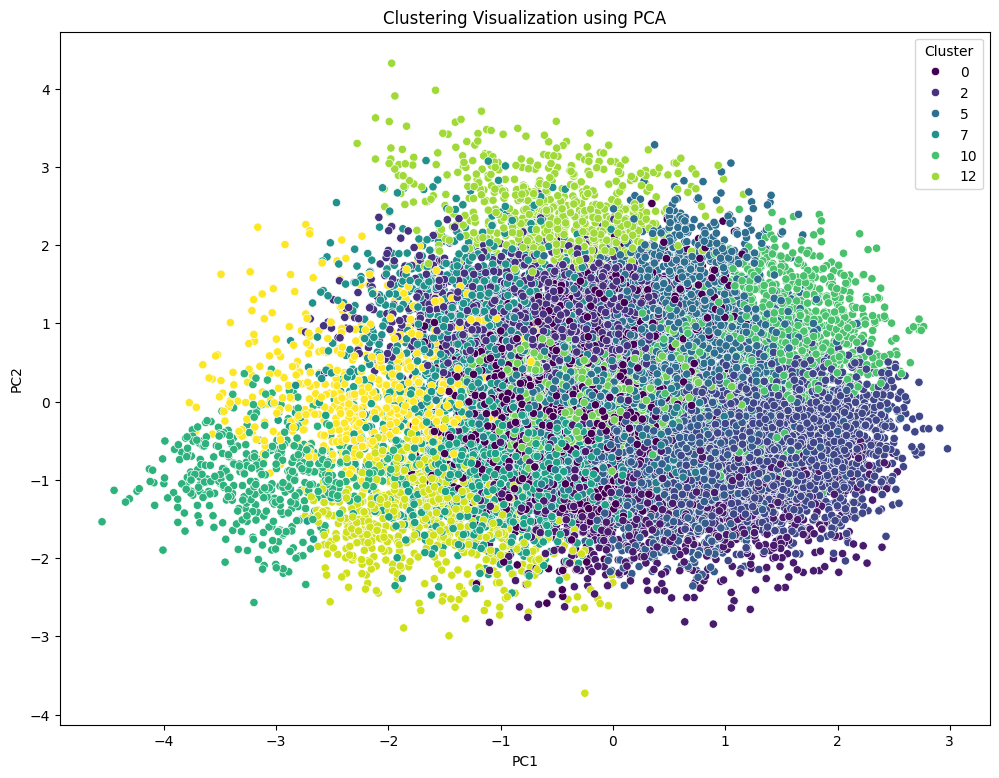

In [26]:
agg = AgglomerativeClustering(n_clusters = 15)
agg_labels = agg.fit_predict(df_scaled)
score = silhouette_score(df_scaled, agg_labels)
print("Silhouette Score: ", score)

pca = PCA(n_components = 2)
df_pca = pca.fit_transform(df_scaled)
df_viz = pd.DataFrame(df_pca, columns = ['PC1', 'PC2'])
df_viz["Cluster"] = agg_labels

plt.figure(figsize = (12, 9))
sns.scatterplot(x = "PC1", y = "PC2", hue = "Cluster", data = df_viz, palette = 'viridis')
plt.title('Clustering Visualization using PCA')

Silhouette Score:  0.16320920553175844


Text(0.5, 1.0, 'Clustering Visualization using PCA')

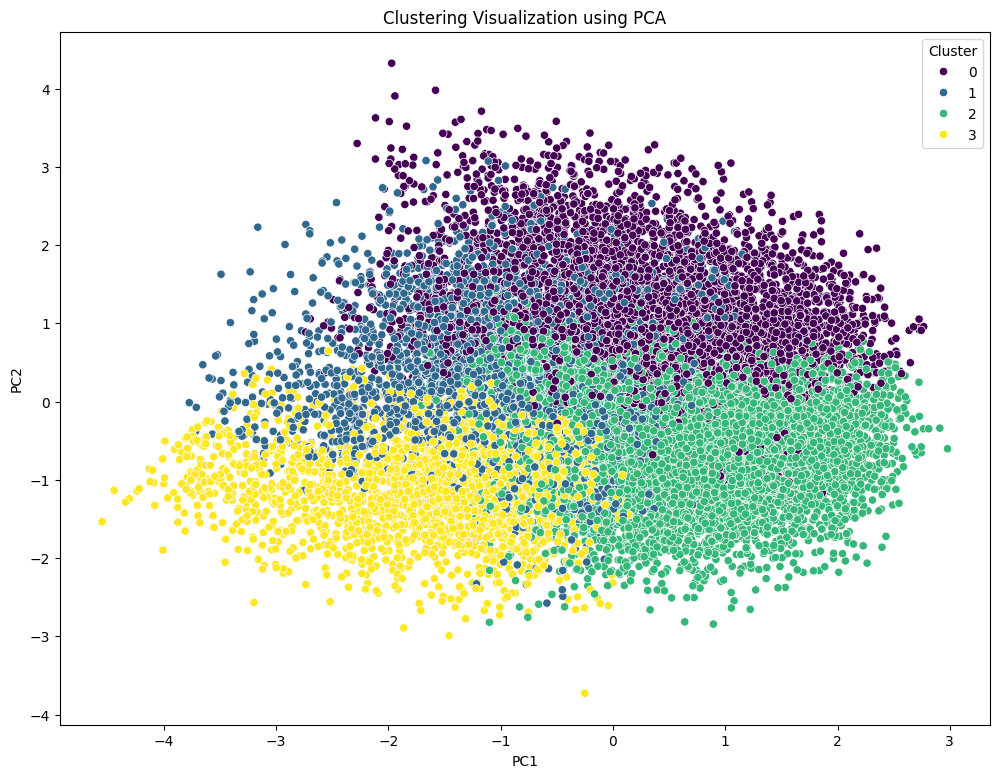

In [27]:
agg = AgglomerativeClustering(n_clusters = 4)
agg_labels = agg.fit_predict(df_scaled)
score = silhouette_score(df_scaled, agg_labels)
print("Silhouette Score: ", score)

pca = PCA(n_components = 2)
df_pca = pca.fit_transform(df_scaled)
df_viz = pd.DataFrame(df_pca, columns = ['PC1', 'PC2'])
df_viz["Cluster"] = agg_labels

plt.figure(figsize = (12, 9))
sns.scatterplot(x = "PC1", y = "PC2", hue = "Cluster", data = df_viz, palette = 'viridis')
plt.title('Clustering Visualization using PCA')

## Step 3: Evaluation

In [28]:
print("KMeans Calinski-Harbrasz Score: ", calinski_harabasz_score(df_scaled, kmeans_labels))
print("KMeans Davies-Bouldin Score: ", davies_bouldin_score(df_scaled, kmeans_labels))
print("Silhouette Score: ", silhouette_score(df_scaled, kmeans_labels))
print("==================================================")

print("GMM Calinski-Harbrasz Score: ", calinski_harabasz_score(df_scaled, gmm_labels))
print("GMM Davies-Bouldin Score: ", davies_bouldin_score(df_scaled, gmm_labels))
print("Silhouette Score: ", silhouette_score(df_scaled, gmm_labels))
print("==================================================")

print("Agglomerative Calinski-Harbrasz Score: ", calinski_harabasz_score(df_scaled, agg_labels))
print("Agglomerative Davies-Bouldin Score: ", davies_bouldin_score(df_scaled, agg_labels))
print("Silhouette Score: ", silhouette_score(df_scaled, agg_labels))

KMeans Calinski-Harbrasz Score:  4210.846793350211
KMeans Davies-Bouldin Score:  1.2504851583433134
Silhouette Score:  0.19926272827541489
GMM Calinski-Harbrasz Score:  5979.422603669043
GMM Davies-Bouldin Score:  1.3712549760291255
Silhouette Score:  0.2228210139865532
Agglomerative Calinski-Harbrasz Score:  4311.658226764134
Agglomerative Davies-Bouldin Score:  1.6305746037972813
Silhouette Score:  0.16320920553175844
